In [1]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("rosbank_train.csv")
raw_data.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [3]:
raw_data.describe()

,cl_id,MCC,currency,amount,target_flag,target_sum
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000,4.905130e+05
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588,1.627345e+05
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148,1.474097e+06
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000,0.000000e+00
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000,0.000000e+00
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000,2.491009e+04
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000,1.516193e+05
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000,4.606578e+07


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns
from geopy.distance import vincenty

C:\Users\Ainur\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


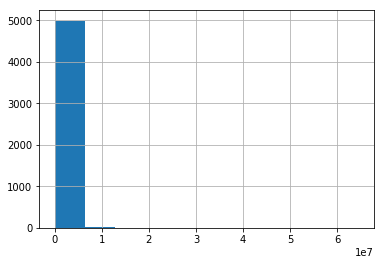

In [7]:
raw_data.groupby('cl_id')['amount'].sum().hist()

In [9]:
raw_data.channel_type.value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

In [17]:
raw_data.MCC.value_counts(normalize=True).head(9)

5411    0.247985
6011    0.110868
5814    0.084302
5812    0.061216
5499    0.055528
5541    0.040399
5912    0.038180
5999    0.026652
6012    0.020501
Name: MCC, dtype: float64

In [25]:
raw_data.groupby('MCC')['amount'].sum().sort_values(ascending = False).head(15)

MCC
6011    1.494000e+09
6012    1.849275e+08
5411    1.346700e+08
7011    9.442452e+07
4829    8.962841e+07
5812    5.341399e+07
4722    4.277184e+07
5712    3.108285e+07
5211    3.059799e+07
4511    2.875367e+07
5722    2.828872e+07
5732    2.781916e+07
5541    2.678864e+07
5691    2.505420e+07
5999    2.240053e+07
Name: amount, dtype: float64

In [26]:
filtered_data = raw_data[raw_data['target_flag']==1]

In [27]:
filtered_data.groupby('MCC')['amount'].sum().sort_values(ascending = False).head(15)

MCC
6011    8.807829e+08
6012    1.090293e+08
5411    8.874367e+07
7011    8.277692e+07
4829    5.645994e+07
5812    4.478597e+07
4722    3.644928e+07
5211    1.951725e+07
4511    1.930900e+07
5691    1.920692e+07
5712    1.794970e+07
5541    1.716527e+07
5722    1.649607e+07
5732    1.605870e+07
5999    1.556268e+07
Name: amount, dtype: float64

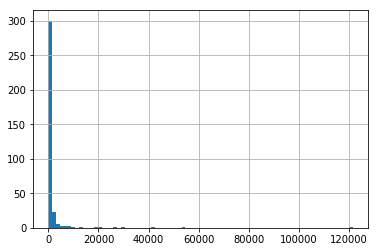

In [45]:
raw_data.MCC.value_counts().hist(bins=80)

In [32]:
(
    raw_data[raw_data['target_flag']==1]['MCC'].value_counts()
    /
    raw_data.MCC.value_counts()
).sort_values(ascending = False)

7841    1.000000
3029    1.000000
7273    1.000000
5978    1.000000
3543    1.000000
3535    1.000000
3513    1.000000
3512    1.000000
3508    1.000000
3013    1.000000
5937    1.000000
3297    1.000000
7623    1.000000
3182    1.000000
7549    1.000000
7534    1.000000
5551    1.000000
3032    1.000000
3502    1.000000
3035    1.000000
5960    1.000000
3405    1.000000
3395    1.000000
3068    1.000000
3393    1.000000
3098    1.000000
7339    1.000000
7333    1.000000
5972    1.000000
3102    1.000000
          ...   
7911    0.200000
8911    0.166667
763     0.153846
5021    0.090909
4457    0.034483
3015         NaN
3028         NaN
3051         NaN
3057         NaN
3058         NaN
3064         NaN
3260         NaN
3387         NaN
3515         NaN
3520         NaN
3545         NaN
3607         NaN
3625         NaN
3628         NaN
3650         NaN
3659         NaN
3678         NaN
3824         NaN
5962         NaN
5965         NaN
5997         NaN
7012         NaN
7519         N

In [49]:
raw_data[raw_data['cl_id']==230]

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
11600,01/03/2017,230,6012,type4,810,07MAR17:16:20:28,10000.0,C2C_OUT,1,79421.5
11601,01/02/2017,230,5999,type4,810,27FEB17:20:34:02,2000.0,POS,1,79421.5
11602,01/04/2017,230,5995,type4,810,30APR17:00:00:00,1141.0,POS,1,79421.5
11603,01/02/2017,230,6011,type4,810,21FEB17:15:17:56,12500.0,DEPOSIT,1,79421.5
11604,01/03/2017,230,5712,type4,810,04MAR17:00:00:00,54285.0,POS,1,79421.5
11605,01/03/2017,230,5411,type4,810,10MAR17:00:00:00,2933.0,POS,1,79421.5
11606,01/03/2017,230,9222,type4,810,22MAR17:00:00:00,580.0,POS,1,79421.5
11607,01/04/2017,230,6012,type4,810,27APR17:16:19:52,30000.0,C2C_OUT,1,79421.5
11608,01/02/2017,230,6011,type4,810,21FEB17:15:19:40,145000.0,DEPOSIT,1,79421.5
11609,01/02/2017,230,6011,type4,810,21FEB17:15:16:34,16000.0,DEPOSIT,1,79421.5


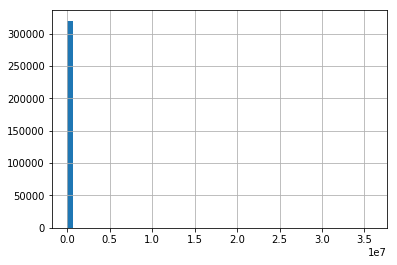

In [53]:
raw_data[raw_data['target_flag']==1]['amount'].hist(bins=50)

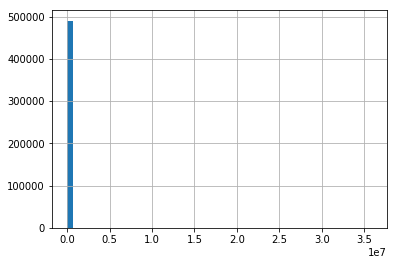

In [54]:
raw_data['amount'].hist(bins=50)

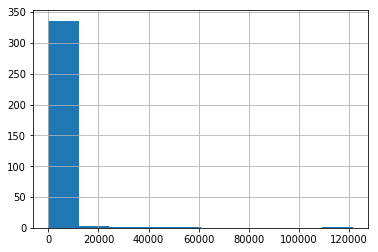

In [57]:
raw_data.MCC.value_counts().hist()

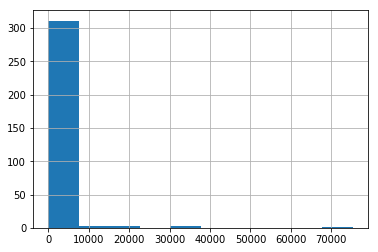

In [58]:
raw_data[raw_data['target_flag']==1]['MCC'].value_counts().hist()

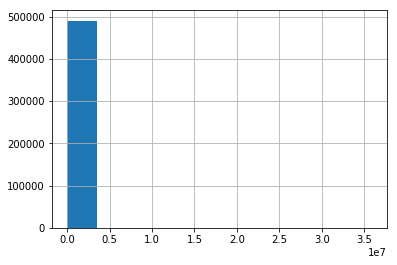

In [59]:
raw_data['amount'].hist()

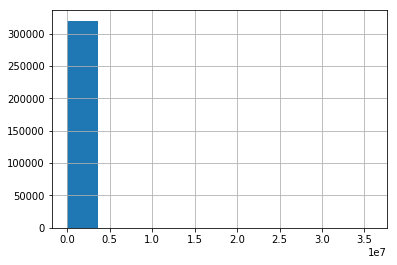

In [60]:
raw_data[raw_data['target_flag']==1]['amount'].hist()

In [65]:
raw_data.channel_type.value_counts(normalize=True)

type1    0.613710
type2    0.358925
type5    0.011458
type4    0.009180
type3    0.006727
Name: channel_type, dtype: float64

In [62]:
raw_data[raw_data['target_flag']==1]['channel_type'].value_counts()

type2    155296
type1    153468
type5      4343
type4      3450
type3      2263
Name: channel_type, dtype: int64

In [64]:
(
    raw_data[raw_data['target_flag']==1]['channel_type'].value_counts()
    /
    raw_data.channel_type.value_counts()
)

type1    0.512847
type2    0.887340
type3    0.689939
type4    0.770777
type5    0.777340
Name: channel_type, dtype: float64

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [67]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    tmp_df = dataset.groupby(['cl_id','day_of_transaction'])['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [old_col for old_col in tmp_df.columns.tolist() if old_col in dataset['day_of_transaction'].unique()]
    tmp_df.rename(columns={old_col: 'day_' + old_col for old_col in old_columns}, inplace=True)
    return tmp_df

In [70]:
transaction_by_day_count(raw_data).sum()

day_of_transaction
cl_id    25561672.0
day_0       62114.0
day_1       65927.0
day_2       68509.0
day_3       69485.0
day_4       71458.0
day_5       78993.0
day_6       74027.0
dtype: float64

In [71]:
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') ) 
    return dataset.groupby(['cl_id','hour_of_transaction'])['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [73]:
transaction_by_hour_count(raw_data)

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
5,11,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0
6,14,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,20,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,21,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
9,22,39.0,0.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [75]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [80]:
def build_new_columns(data):
    
    sum_by_trx_category_dict = data.trx_category.value_counts().to_dict()
    data['sum_by_trx_category'] = data['trx_category'].apply(sum_by_trx_category_dict.get)
    
    sum_by_mcc_dict = data.MCC.value_counts().to_dict()
    data['sum_by_mcc'] = data['MCC'].apply(sum_by_mcc_dict.get)
    
    sum_by_currency_dict = data.currency.value_counts().to_dict()
    data['sum_by_currency'] = data['currency'].apply(sum_by_currency_dict.get)
    
    sum_by_channel_type_dict = data.channel_type.value_counts().to_dict()
    data['sum_by_channel_type'] = data['channel_type'].apply(sum_by_channel_type_dict.get)
    
    data['hour_of_transaction'] = data['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H') )
    
    data['day_of_transaction'] = data['TRDATETIME'].apply( lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w') ) 
    
    data = get_one_hot(
        data,
        ['channel_type', 'trx_category', 'hour_of_transaction', 'day_of_transaction']
    )
    

    data = data.drop(
        labels=['channel_type', 'trx_category', 'hour_of_transaction', 'day_of_transaction'],
        axis=1
    )
    
    return data

In [77]:
cl_ids_test = np.random.choice(raw_data.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [79]:
transactions_train = raw_data[~raw_data.cl_id.isin(cl_ids_test)].copy()

transactions_test = raw_data[raw_data.cl_id.isin(cl_ids_test)].copy()

In [ ]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

In [ ]:
columns_to_get_counts = [
    'MCC',
    'currency',
]
    
for col_get_prob in columns_to_get_counts:
    transactions_train, transactions_test = get_woe_v1(transactions_train, transactions_test, col_get_prob, 'target_flag')